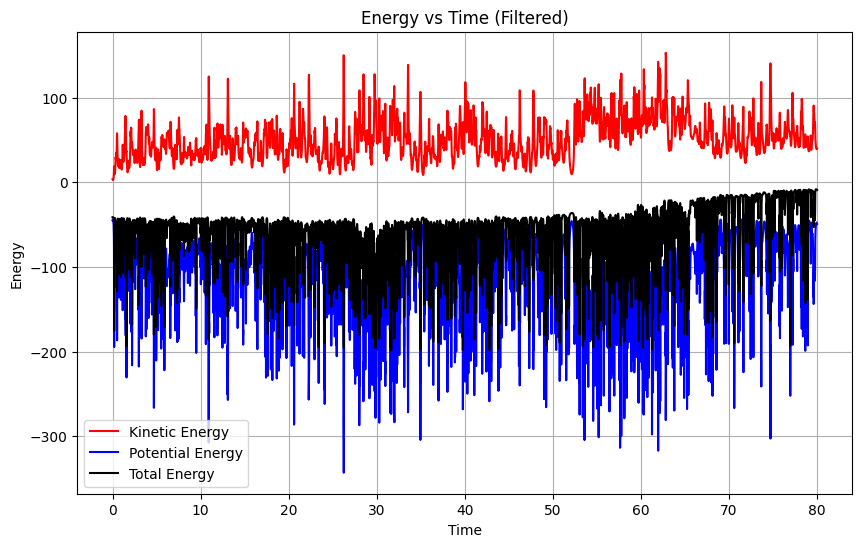

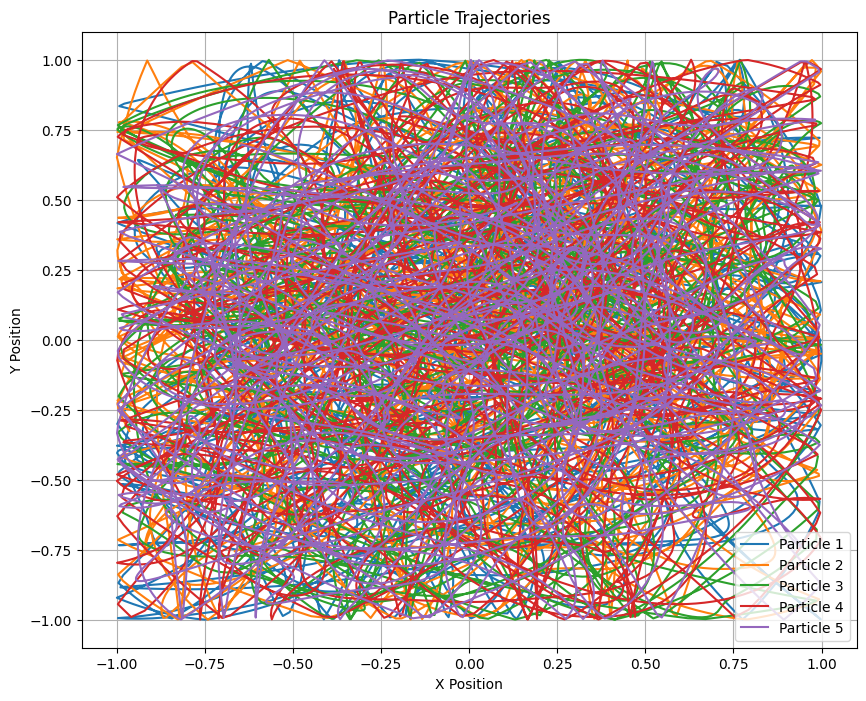

In [11]:
import matplotlib
import wandb
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import utils.nbody_utils as ut
import importlib
import utils.loggers as loggers

importlib.reload(ut)

seed_value = 42

N = 5  # Number of particles
tEnd = 80.0  # time at which simulation ends
dt = 0.01  # timestep
softening = 0.15  # softening length
G = 1.0  # Newton's Gravitational Constant
boxSize = 1.0
mass_coef = 10.0 
dims = 2
LOG_WANDB = False

hparams = {
    'N': N,  # Number of particles
    'tEnd': tEnd,  # Time at which simulation ends
    'dt': dt,  # Timestep
    'G': G,  # Newton's Gravitational Constant
    'boxSize': boxSize,  # Size of the simulation box
    'mass_coef': mass_coef  # Mass coefficient
}

combined_data = ut.simulate_gravitational_system(seed_value, N, tEnd, dt, softening, G, boxSize, mass_coef, dims=dims,
                                                 init_boxsize=boxSize)


In [12]:
# %matplotlib qt
# ut.interactive_trajectory_plot_just_sim(combined_data, particle_index=None, boxSize=boxSize, dims=dims)
# %matplotlib inline

combined_data shape: (7844, 5, 4)
inputs_np shape: (7843, 5, 4)
targets_np shape: (7843, 5, 4)


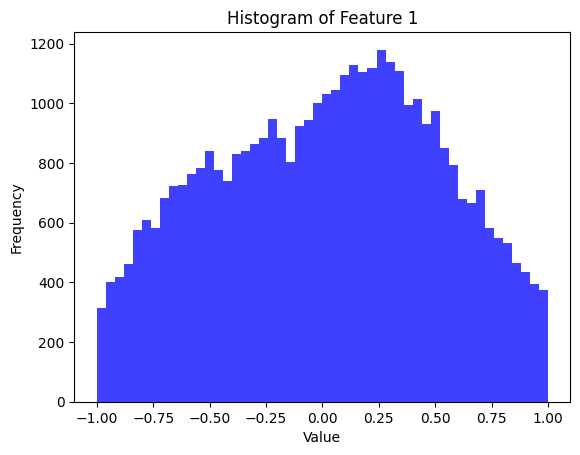

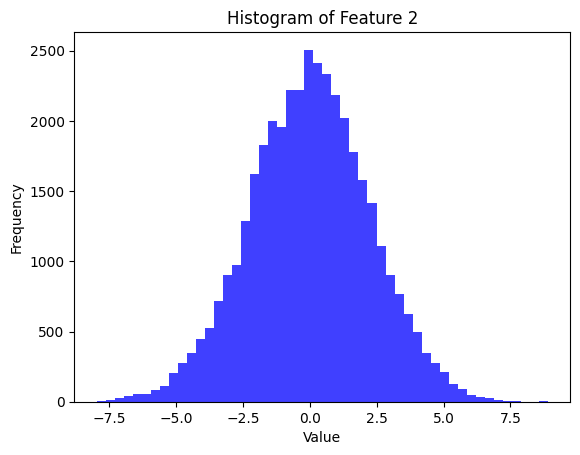

Normalized:


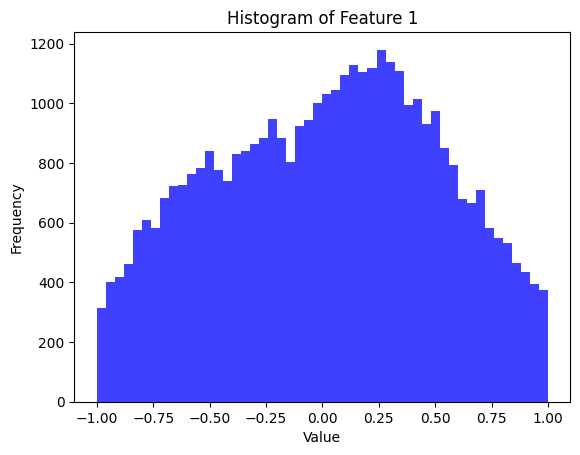

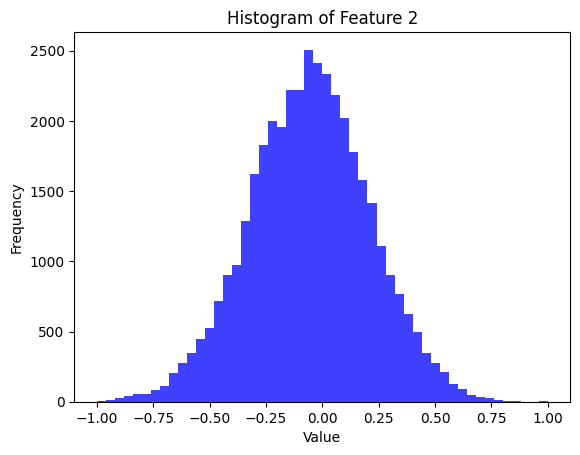

In [13]:
inputs_np, targets_np = ut.process_data(combined_data, dims=dims)

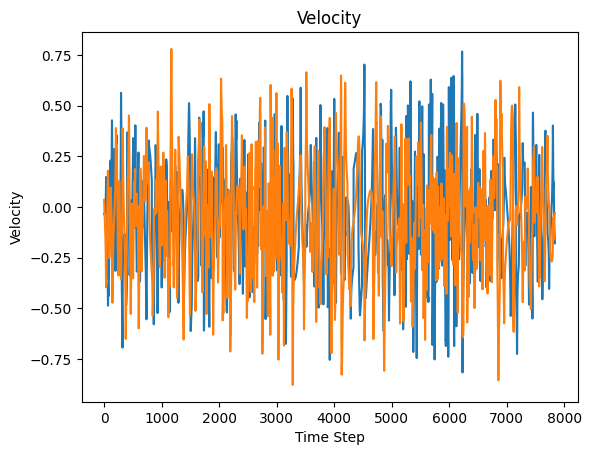

In [14]:
#time_steps = np.arange(mse_values.shape[0])  # Generate an array of time steps
plt.figure()
plt.plot(inputs_np[:, 0, 2:])  # Plot MSE values against time steps

plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title('Velocity')
plt.show()

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
from datetime import datetime
import models

torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

activation = 'relu'
mlp_activation = nn.Tanh
particle_dim = 2 * dims  # 3 for position and 3 for velocity
model_dim = 256
num_heads = 4
num_layers = 1
hidden_dims = [model_dim, model_dim, model_dim]
lr = 0.001
batch_size = 128
particle_index = 0
precision = 'double'
mlp_type = 'output'
model_dict = {
    'particle_dim': particle_dim,  # 3 for position and 3 for velocity
    'model_dim': model_dim,
    'num_heads': num_heads,
    'num_layers': num_layers,
    'hidden_dims': str(hidden_dims),
    'lr': lr,
    'batch_size': batch_size,
    'activation': activation,
    'precision': precision,
    'mlp_type': mlp_type,
}
hparams.update(model_dict)

#experiment
current_time = datetime.now().strftime('%Y-%m-%d %H-%M')
experiment_name = "encoder_one_particle_mlp_v2"
run_name = f'{activation}_{current_time}_l1_{str(model_dim)}_{str(num_heads)}_{str(num_layers)}_{str(batch_size)}_{str(lr)}_double_{dims}_{str(hidden_dims).replace("[", "(").replace("]", ")")}_{str(mlp_activation.__name__)}_mlp{mlp_type}'
experiment_folder = os.path.join(experiment_name, run_name)
writer = SummaryWriter(experiment_folder)

loggers_list = [loggers.TensorBoardLogger(writer)]

if LOG_WANDB and loggers.WandBLogger.get_api_key() is not None:
    wandb_logger = loggers.WandBLogger(project_name=experiment_name, run_name=run_name, config=hparams)
    loggers_list.append(wandb_logger)

np.savez(os.path.join(experiment_folder, 'data_arrays.npz'), inputs=inputs_np, targets=targets_np)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.EncoderWithMLP(particle_dim=particle_dim,
                              model_dim=model_dim,
                              num_heads=num_heads,
                              num_layers=num_layers,
                              particle_index=particle_index,
                              activation=activation,
                              hidden_dims=hidden_dims,
                              mlp_act=nn.ReLU,
                              mlp_type=mlp_type,
                              mlp_output_act=nn.Tanh,
                              hparams=hparams
                              ).to(device)

inputs_tensor = torch.tensor(inputs_np, dtype=torch.float64)
targets_tensor = torch.tensor(targets_np, dtype=torch.float64)
dataset = TensorDataset(inputs_tensor.to(device).double(), targets_tensor[:, particle_index, :].to(device).double())
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 1500
epoch = 0

cpu


In [16]:
import importlib

importlib.reload(ut)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epoch, loss = ut.train_model(model, optimizer, criterion, data_loader, num_epochs, old_epoch=epoch,
                             loggers=loggers_list,
                             dims=dims)


training
Epoch [2/1500], avg_both: 0.07592, avg_pos:  0.08694, avg_vel:  0.06489, perc_pos:  27.61603%, perc_vel:  42.76368%
Epoch [3/1500], avg_both: 0.03038, avg_pos:  0.02769, avg_vel:  0.03308, perc_pos:  8.69673%, perc_vel:  22.48561%
Epoch [4/1500], avg_both: 0.02481, avg_pos:  0.02109, avg_vel:  0.02854, perc_pos:  6.77914%, perc_vel:  19.49855%
Epoch [5/1500], avg_both: 0.02238, avg_pos:  0.01905, avg_vel:  0.02570, perc_pos:  6.14586%, perc_vel:  17.26870%
Epoch [6/1500], avg_both: 0.01972, avg_pos:  0.01523, avg_vel:  0.02421, perc_pos:  4.85085%, perc_vel:  16.47006%
Saving model at the end of training


In [17]:
criterion = nn.L1Loss()
num_epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=lr * 0.1)
data_loader = DataLoader(dataset, batch_size=int(batch_size), shuffle=True)
epoch, loss = ut.train_model(model, optimizer, criterion, data_loader, num_epochs, old_epoch=epoch,
                             loggers=loggers_list,
                             dims=dims)

training
Saving model at the end of training


In [18]:
predicted_data = ut.get_predicted_data(model, dataset.tensors[0], particle_index)
ut.plot_trajectory(targets_np, predicted_data, particle_index=particle_index, loggers=loggers_list, epoch=epoch,
                   dims=dims)

ut.plot_error_over_time_position(targets_np, predicted_data, particle_index, loggers=loggers_list, epoch=epoch,
                                 dims=dims)

ut.plot_error_over_time_velocity(targets_np, predicted_data, particle_index, loggers=loggers_list, epoch=epoch,
                                 dims=dims)
for lg in loggers_list:
    lg.log_hparams(hparams, loss)


KeyboardInterrupt



In [ ]:
import importlib

importlib.reload(ut)
sim_steps = min(targets_np.shape[0], 1000)
ut.interactive_trajectory_plot_all_particles(targets_np[0:sim_steps, ...], predicted_data[0:sim_steps, ...],
                                             particle_index,
                                             boxSize=boxSize, dims=dims, offline_plot=True, loggers=loggers_list,
                                             video_tag=f"One step prediction of a particle {particle_index}")

In [ ]:
for self_feed_reset in [120, 1000]:
    number_of_predictions = 1001
    reset_every = self_feed_reset
    predicted_data_self_feed = ut.self_feed(model, dataset.tensors[0], number_of_predictions=number_of_predictions,
                                            reset_every=reset_every)
    fig = ut.interactive_trajectory_plot_all_particles(targets_np[0:number_of_predictions, ...],
                                                       predicted_data_self_feed[0:number_of_predictions, ...],
                                                       particle_index,
                                                       boxSize=boxSize * 1.5, dims=dims, offline_plot=True,
                                                       loggers=loggers_list,
                                                       video_tag=f"Self feed {number_of_predictions} steps reset every {self_feed_reset}")

In [ ]:
for lg in loggers_list:
    lg.log_scalar('last_epoch', epoch)
    lg.finish()

In [ ]:
import os
import sys

# Your notebook code here
# ...

# Shutdown command
if sys.platform == "win32":  # For Windows
    os.system("shutdown /s /t 1")
elif sys.platform == "linux" or sys.platform == "linux2":  # For Linux
    os.system("shutdown now")
elif sys.platform == "darwin":  # For macOS
    os.system("sudo shutdown -h now")